# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Histogram of Oriented Gradients (HOG)

Total # images:  17760
Total # of notcars:  8968
Total # of cars:  8792


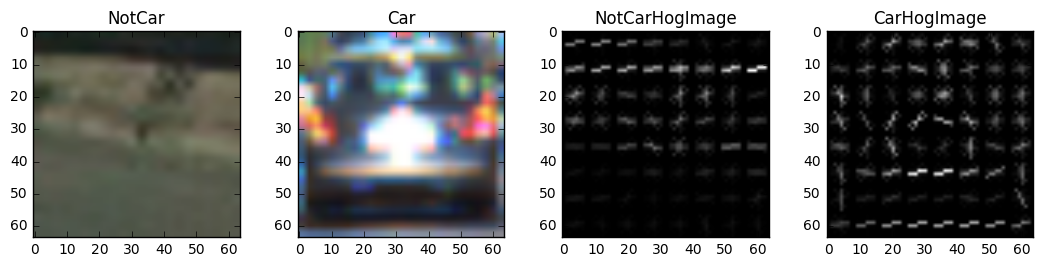

In [169]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import glob

%matplotlib inline

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
ystart = 400

ystop = 656
scale = 1.5
spatial_size = (32, 32)
hist_bins = 32

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Read in car and non-car images
images = glob.glob("/Users/manuelstuefer/PycharmProjects/CarND-Vehicle-Detection/images/*/*/*.png")
print("Total # images: ", len(images))
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Balance dataset
# ...remove some notcars_images 
# notcars = notcars[:len(cars)]
# cars = cars[:len(notcars)]

print("Total # of notcars: ", len(notcars))
print("Total # of cars: ", len(cars))

##########################
# Speedup during testing
# cars = cars[:1000]
# notcars = notcars[:1000]

img_ind = np.random.randint(0, min(len(cars), len(notcars)))

notcar = mpimg.imread(notcars[img_ind])
gnotcar = cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY)
_, notcar_hog_image = get_hog_features(gnotcar, orient, pix_per_cell, cell_per_block, True, True)

car = mpimg.imread(cars[img_ind])
gcar = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
_, car_hog_image = get_hog_features(gcar, orient, pix_per_cell, cell_per_block, True, True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 8))
f.tight_layout()
ax1.imshow(notcar, cmap='gray')
ax1.set_title('NotCar', fontsize=12)
ax2.imshow(car, cmap='gray')
ax2.set_title('Car', fontsize=12)
ax3.imshow(notcar_hog_image, cmap='gray')
ax3.set_title('NotCarHogImage', fontsize=12)
ax4.imshow(car_hog_image, cmap='gray')
ax4.set_title('CarHogImage', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [243]:
# Classifier training

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# def convert_color(img, conv='RGB2YCrCb'):
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, spatial_size=(32, 32), hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255
        feature_image = convert_color(image)
        
        # ALL hog_channel
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]        
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog_features = np.hstack((hog1, hog2, hog3))
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins)
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(scaled_X.shape)
    # Define labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    # Use a linear SVC 
    svc = LinearSVC()
    # Train
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
else: 
    raise ValueError("car_features empty")

(17760, 8460)


Test Accuracy of SVC =  0.9879


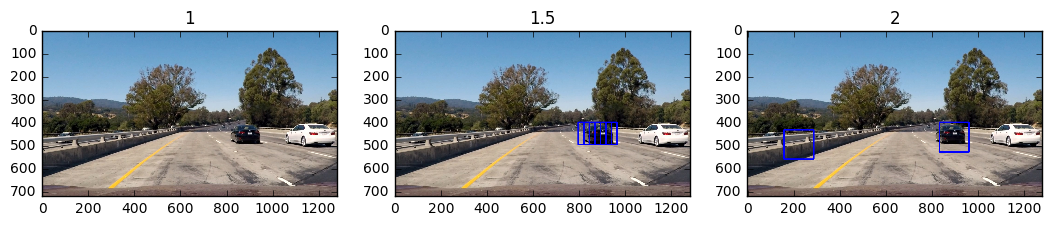

In [249]:
# Sliding Window Search

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bbox = []

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # ALL hog_channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
                bbox.append(box)

    return draw_img, bbox


test_img = mpimg.imread("test_images/test1.jpg")
final_box_list = []
scale = 2
out_img20, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)
scale = 1.5
out_img15, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)
scale = 10
out_img10, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(out_img10)
ax1.set_title('1', fontsize=12)
ax2.imshow(out_img15)
ax2.set_title('1.5', fontsize=12)
ax3.imshow(out_img20)
ax3.set_title('2', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
final_box_list = [item for sublist in final_box_list for item in sublist]

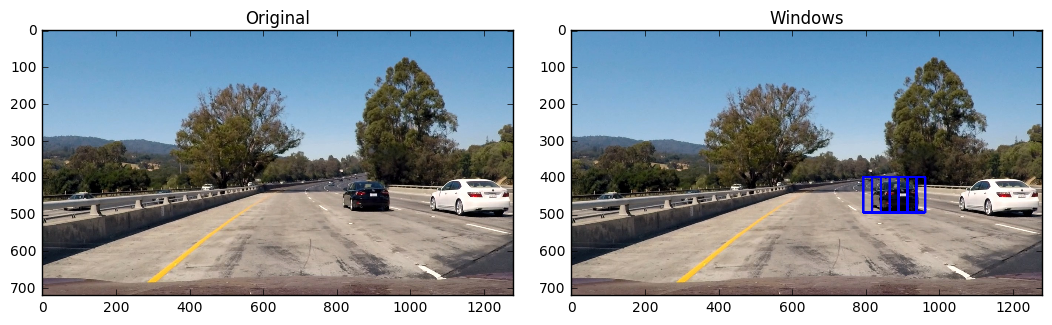

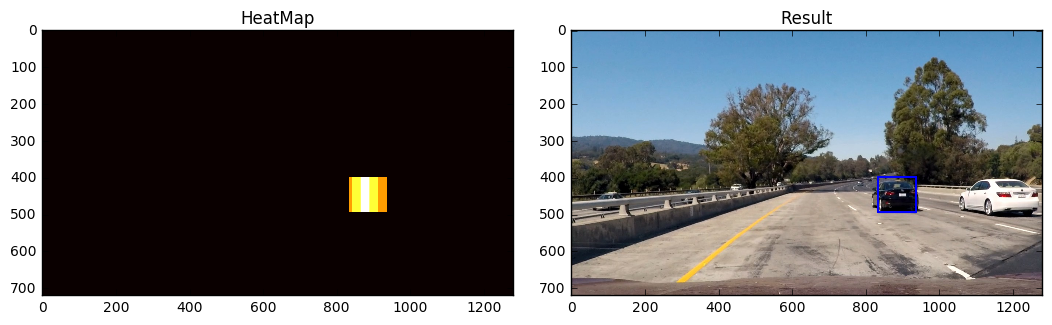

In [252]:
# Heatmap

from scipy.ndimage.measurements import label

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,final_box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

# plt.imshow(heatmap, cmap="hot")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(test_img, cmap='gray')
ax1.set_title('Original', fontsize=12)
ax2.imshow(out_img15, cmap='gray')
ax2.set_title('Windows', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax3.imshow(heatmap, cmap='hot')
ax3.set_title('HeatMap', fontsize=12)
ax4.imshow(draw_img, cmap='gray')
ax4.set_title('Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

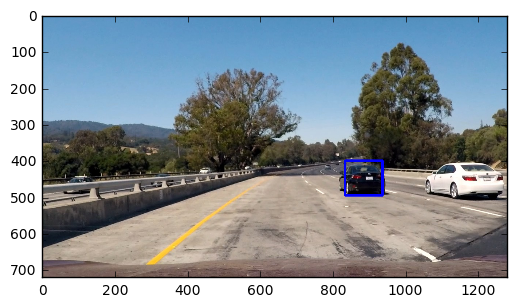

In [264]:
# Video ImagePipeline

def process_image(original_image):
    final_box_list = []
    scale = 1
    out_img10, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)
    
    scale = 1.5
    out_img15, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)

    scale = 2
    out_img20, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)
    
    final_box_list = [item for sublist in final_box_list for item in sublist]
    
    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,final_box_list)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    # labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(original_image), labels)
    
    return draw_img 

plt.imshow(process_image(test_img))

In [265]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

output = "project_output_video.mp4"
clip = VideoFileClip("./test_video.mp4")
new_clip = clip.fl_image(process_image)
new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4


[MoviePy] Writing video project_output_video.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:01<01:11,  1.89s/it]

  5%|▌         | 2/39 [00:03<01:09,  1.88s/it]

  8%|▊         | 3/39 [00:05<01:06,  1.85s/it]

 10%|█         | 4/39 [00:07<01:04,  1.84s/it]

 13%|█▎        | 5/39 [00:09<01:02,  1.84s/it]

 15%|█▌        | 6/39 [00:11<01:08,  2.09s/it]

 18%|█▊        | 7/39 [00:15<01:17,  2.42s/it]

 21%|██        | 8/39 [00:17<01:18,  2.52s/it]

 23%|██▎       | 9/39 [00:20<01:17,  2.60s/it]

 26%|██▌       | 10/39 [00:22<01:10,  2.43s/it]

 28%|██▊       | 11/39 [00:24<01:02,  2.25s/it]

 31%|███       | 12/39 [00:26<00:57,  2.13s/it]

 33%|███▎      | 13/39 [00:28<00:53,  2.04s/it]

 36%|███▌      | 14/39 [00:30<00:51,  2.04s/it]

 38%|███▊      | 15/39 [00:31<00:47,  1.98s/it]

 41%|████      | 16/39 [00:33<00:44,  1.92s/it]

 44%|████▎     | 17/39 [00:35<00:41,  1.89s/it]

 46%|████▌     | 18/39 [00:37<00:39,  1.87s/it]

 49%|████▊     | 19/39 [00:39<00:37,  1.86s/it]

 51%|█████▏    | 20/39 [00:41<00:35,  1.84s/it]

 54%|█████▍    | 21/39 [00:43<00:33,  1.87s/it]

 56%|█████▋    | 22/39 [00:44<00:31,  1.87s/it]

 59%|█████▉    | 23/39 [00:46<00:29,  1.87s/it]

 62%|██████▏   | 24/39 [00:48<00:27,  1.86s/it]

 64%|██████▍   | 25/39 [00:50<00:25,  1.85s/it]

 67%|██████▋   | 26/39 [00:52<00:23,  1.84s/it]

 69%|██████▉   | 27/39 [00:54<00:22,  1.91s/it]

 72%|███████▏  | 28/39 [00:56<00:21,  2.00s/it]

 74%|███████▍  | 29/39 [00:59<00:21,  2.15s/it]

 77%|███████▋  | 30/39 [01:01<00:20,  2.25s/it]

 79%|███████▉  | 31/39 [01:03<00:18,  2.31s/it]

 82%|████████▏ | 32/39 [01:06<00:16,  2.42s/it]

 85%|████████▍ | 33/39 [01:08<00:14,  2.40s/it]

 87%|████████▋ | 34/39 [01:11<00:11,  2.31s/it]

 90%|████████▉ | 35/39 [01:13<00:09,  2.27s/it]

 92%|█████████▏| 36/39 [01:15<00:06,  2.30s/it]

 95%|█████████▍| 37/39 [01:17<00:04,  2.24s/it]

 97%|█████████▋| 38/39 [01:19<00:02,  2.25s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output_video.mp4 

